# Załadowanie bibliotek

In [1]:

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage.filters import frangi
from skimage.color import rgb2gray
from skimage.morphology import closing, square
from skimage.morphology import remove_small_objects
from skimage.morphology import skeletonize
from skimage.measure import moments_central, moments_hu
import skimage.exposure as exp
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.metrics import BinaryIoU
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown
from sklearn.metrics import confusion_matrix
from joblib import dump
from joblib import load
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

2025-06-12 18:51:37.021199: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-12 18:51:37.158191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749747097.226453    9890 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749747097.247225    9890 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749747097.358390    9890 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Proste przetwarzanie z wyborem

In [3]:
# Ścieżka do folderu z obrazami
image_dir = 'images2'

# Lista dostępnych obrazów .jpg (bez masek .ah)
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') and '.ah' not in f]
image_files.sort()

@interact(filename=Dropdown(options=image_files, description='Obraz:'))
def run_pipeline(filename):
    image_path = os.path.join(image_dir, filename)
    ah_path = image_path.replace('.jpg', '.tif')

    # 1. Wczytaj kolorowy obraz (BGR)
    img = cv2.imread(image_path)
    ideal_result = cv2.imread(ah_path, 0) > 0

    # 2. Rozmycie i ekstrakcja kanału zielonego
    img_blur = cv2.GaussianBlur(img, (5, 5), 0)
    green_channel = img_blur[:, :, 1]  # zielony kanał (G)

    # 3. Maska FOV na podstawie zielonego kanału
    _, fov_mask = cv2.threshold(green_channel, 10, 255, cv2.THRESH_BINARY)
    fov_mask = fov_mask > 0

    # 4. CLAHE na zielonym kanale
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    g_clahe = clahe.apply(green_channel)

    # 5. Normalizacja i konwersja do float [0,1]
    gray = g_clahe / 255.0

    # 6. Filtr Frangiego
    frangi_result = frangi(gray)
    frangi_result[~fov_mask] = 0
    thr = np.percentile(frangi_result[fov_mask], 93)
    binary = (frangi_result > thr) & fov_mask

    # 7. Obróbka morfologiczna
    binary_closed = closing(binary, square(3))
    binary_cleaned = remove_small_objects(binary_closed, min_size=25)
    binary_skeleton = skeletonize(binary_cleaned)

    # Wyświetlanie wyników
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Oryginalny")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Kanał zielony po CLAHE")
    plt.imshow(gray, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Maska FOV")
    plt.imshow(fov_mask, cmap='gray')
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Po filtrze frangiego")
    plt.imshow(frangi_result, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Po domknięciu naczyń")
    plt.imshow(binary_closed, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Po usunięciu szumów")
    plt.imshow(binary_cleaned, cmap='gray')
    plt.axis('off')
    plt.show()

    # Obraz referencyjny
    plt.figure(figsize=(5, 5))
    plt.title("Obraz referencyjny (idealny)")
    plt.imshow(ideal_result, cmap='gray')
    plt.axis('off')
    plt.show()

    # Oblicz metryki
    TP = np.logical_and(binary_cleaned == 1, ideal_result == 1).sum()
    TN = np.logical_and(binary_cleaned == 0, ideal_result == 0).sum()
    FP = np.logical_and(binary_cleaned == 1, ideal_result == 0).sum()
    FN = np.logical_and(binary_cleaned == 0, ideal_result == 1).sum()

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    balanced_accuracy = (sensitivity + specificity) / 2

    cm = confusion_matrix(ideal_result.flatten(), binary_cleaned.flatten())
    print("Confusion matrix:\n", cm)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")


interactive(children=(Dropdown(description='Obraz:', options=('01_h.jpg', '02_h.jpg', '03_h.jpg', '04_h.jpg', …

# Odczyt danych do klasyfikatorów

In [4]:
# Parametry
window_size = 10
step = 10
image_dir = "images2"

# Wczytaj obrazy i maski
images = []
masks = []
for i in range(1, 8):
    images.append(cv2.imread(f"{image_dir}/0{i}_h.jpg"))
    masks.append(cv2.imread(f"{image_dir}/0{i}_h.tif", cv2.IMREAD_GRAYSCALE))

# Ekstrakcja cech
features, labels, rows = [], [], []
for idx in range(len(images)):
    img = images[idx]
    mask = masks[idx]

    img_blur = cv2.GaussianBlur(img, (5, 5), 0)
    green_channel = img_blur[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    g_clahe = clahe.apply(green_channel)
    gray = g_clahe / 255.0
    
    h, w = gray.shape
    for y in range(0, h - window_size + 1, step):
        for x in range(0, w - window_size + 1, step):
            patch = gray[y:y+window_size, x:x+window_size]
            var = np.var(patch)
            hu = moments_hu(moments_central(patch))
            label = mask[y + window_size // 2, x + window_size // 2]
            row = {"var": var, **{f"hu_{i}": hu[i] for i in range(7)}, "label": label}
            rows.append(row)
            features.append(np.concatenate([[var], hu]))
            labels.append(label)

# Przygotowanie danych
data = pd.DataFrame(rows)
X = data.iloc[:, :-1]
y_train = data.iloc[:, -1]

# Skalowanie i balansowanie
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(scaled_data, y_train)

# Samodzielne uczenie Klasyfikatorów (opcjonalne)

In [ ]:

# Trening SVM
svm_model = svm.SVC(kernel='linear', C=1, class_weight='balanced')
svm_model.fit(X_train, y_train)

# Trening k-NN
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=6)
knn_model.fit(X_train, y_train)

print("Modele SVM i k-NN wytrenowane.")


KeyboardInterrupt: 

# Zapis modelu

In [12]:
dump(svm_model, 'svm_model.joblib')
dump(knn_model, 'knn_model.joblib')

['knn_model.joblib']

# Odczyt modelu

In [5]:
svm_model = load('svm_model.joblib')
knn_model = load('knn_model.joblib')

# Wybór pliku

In [6]:

# Lista dostępnych obrazów
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') and '.ah' not in f]
image_files.sort()

selected_filename = None
ideal_img = None 

# Obsługa wyboru
def on_image_selected(change):
    global selected_filename, ideal_img
    selected_filename = change['new']
    ideal_filename = selected_filename.replace('.jpg', '.tif')

    # Wczytanie i konwersja do wartości binarnych (0 i 1) jako uint8
    img = cv2.imread(f"{image_dir}/{ideal_filename}", cv2.IMREAD_GRAYSCALE)
    ideal_img = (img > 127).astype(np.uint8)

    print(f"Wybrano obraz testowy: {selected_filename}")

# Dropdown
dropdown = Dropdown(options=image_files, description="Obraz:")
dropdown.observe(on_image_selected, names='value')
display(dropdown)


Dropdown(description='Obraz:', options=('01_h.jpg', '02_h.jpg', '03_h.jpg', '04_h.jpg', '05_h.jpg', '06_h.jpg'…

Wybrano obraz testowy: 02_h.jpg
Wybrano obraz testowy: 01_h.jpg
Wybrano obraz testowy: 11_h.jpg


# Załadowanie pliku oraz wynik SVM

/home/filip/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


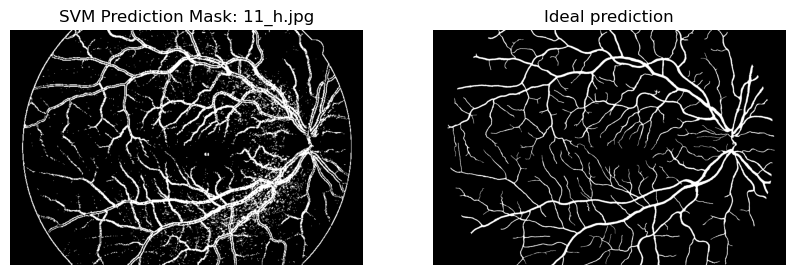

Confusion matrix:
[[6719829  700532]
 [ 237665  527318]]

Accuracy: 0.8854
Sensitivity (Recall): 0.6893
Specificity: 0.9056
Balanced Accuracy: 0.7975


/tmp/ipykernel_9890/3272310052.py:50: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  pred_binary = remove_small_objects(pred_binary, min_size=25)


In [8]:
# Wczytanie obrazu testowego
window_size = 10
step = 10
test_img = cv2.imread(f"{image_dir}/{selected_filename}")
img_blur = cv2.GaussianBlur(test_img, (5, 5), 0)
green_channel = img_blur[:, :, 1]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
g_clahe = clahe.apply(green_channel)
gray = g_clahe / 255.0

h, w = gray.shape
step_test = 5
test_positions, test_features, test_rows = [], [], []

for y in range(0, h - window_size + 1, step_test):
    for x in range(0, w - window_size + 1, step_test):
        patch = gray[y:y+window_size, x:x+window_size]
        var = np.var(patch)
        hu = moments_hu(moments_central(patch))
        row = {"var": var, **{f"hu_{i}": hu[i] for i in range(7)}}
        test_rows.append(row)
        test_features.append(np.concatenate([[var], hu]))
        test_positions.append((y, x))

test_data = pd.DataFrame(test_rows)
X_test_scaled = scaler.transform(np.array(test_data))
y_final = svm_model.predict(X_test_scaled)

# Rekonstrukcja maski
grid_h = (h - window_size) // step_test + 1
grid_w = (w - window_size) // step_test + 1
output_mask = np.zeros_like(gray, dtype=np.uint8)
for idx, (y, x) in enumerate(test_positions):
    output_mask[y:y+window_size, x:x+window_size] = y_final[idx]

# Wyświetlenie
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(output_mask, cmap='gray')
plt.title(f"SVM Prediction Mask: {selected_filename}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ideal_img, cmap='gray')
plt.title(f"Ideal prediction")
plt.axis('off')
plt.show()

pred_binary = (output_mask > 0).astype(np.uint8)
pred_binary = remove_small_objects(pred_binary, min_size=25)
ideal_binary = (ideal_img > 0).astype(np.uint8)

# macierz pomyłek
cm = confusion_matrix(ideal_binary.flatten(), pred_binary.flatten())
print("Confusion matrix:")
print(cm)

TP = np.logical_and(pred_binary == 1, ideal_binary == 1).sum()
TN = np.logical_and(pred_binary == 0, ideal_binary == 0).sum()
FP = np.logical_and(pred_binary == 1, ideal_binary == 0).sum()
FN = np.logical_and(pred_binary == 0, ideal_binary == 1).sum()

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
balanced_accuracy = (sensitivity + specificity) / 2

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")





# Wynik KNN

In [9]:
# Predykcja i rekonstrukcja maski k-NN
y_final_knn = knn_model.predict(X_test_scaled)

output_mask_knn = np.zeros_like(gray, dtype=np.uint8)
for idx, (y, x) in enumerate(test_positions):
    output_mask_knn[y:y+window_size, x:x+window_size] = y_final_knn[idx]

# Wyświetlenie
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(output_mask_knn, cmap='gray')
plt.title(f"k-NN Prediction Mask: {selected_filename}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ideal_img, cmap='gray')
plt.title(f"Ideal prediction")
plt.axis('off')

plt.show()

pred_binary = (output_mask_knn > 0).astype(np.uint8)
pred_binary = remove_small_objects(pred_binary, min_size=25)
ideal_binary = (ideal_img > 0).astype(np.uint8)

# macierz pomyłek
cm = confusion_matrix(ideal_binary.flatten(), pred_binary.flatten())
print("Confusion matrix:")
print(cm)

TP = np.logical_and(pred_binary == 1, ideal_binary == 1).sum()
TN = np.logical_and(pred_binary == 0, ideal_binary == 0).sum()
FP = np.logical_and(pred_binary == 1, ideal_binary == 0).sum()
FN = np.logical_and(pred_binary == 0, ideal_binary == 1).sum()

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
balanced_accuracy = (sensitivity + specificity) / 2

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")



NameError: name 'knn_model' is not defined

# Wczytywanie obrazów do głębokiego uczenia

In [2]:
images = []
masks = []

for i in range(1, 13):
    images.append(cv2.imread(f"images2/{i:02d}_h.jpg"))
    masks.append(cv2.imread(f"images2/{i:02d}_h.tif", cv2.IMREAD_GRAYSCALE))

# Parametry patchy
window_size = 20
step = 10
patches = []
labels = []
positions = []

for idx in range(len(images)):
    image = images[idx]
    mask = masks[idx]

    # # Rozmycie i CLAHE
    # img_blur = cv2.GaussianBlur(image, (5, 5), 0)
    # b, g, r = cv2.split(image)
    # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # b_clahe = clahe.apply(b)
    # g_clahe = clahe.apply(g)
    # r_clahe = clahe.apply(r)
    # img_eq = cv2.merge((b_clahe, g_clahe, r_clahe))

    # # Na szaro
    # img_rgb = cv2.cvtColor(img_eq, cv2.COLOR_BGR2RGB)
    # gray = rgb2gray(img_eq)
    # gray = (gray * 255).astype('uint8')  # konwersja do 0–255, jak maska
    
    img_blur = cv2.GaussianBlur(image, (5, 5), 0)
    green_channel = img_blur[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    g_clahe = clahe.apply(green_channel)
    gray = (g_clahe * 255).astype('uint8')

    h, w = gray.shape

    for y in range(0, h - window_size + 1, step):
        for x in range(0, w - window_size + 1, step):
            center_y = y + window_size // 2
            center_x = x + window_size // 2

            # Sprawdź, czy środek patcha mieści się w obrazie i masce
            if center_y >= h or center_x >= w:
                continue

            patch = gray[y:y+window_size, x:x+window_size].astype('float32') / 255.0
            patch = patch[..., np.newaxis]

            label = mask[center_y, center_x]
            label = 1 if label > 0 else 0

            patches.append(patch)
            labels.append(label)
            positions.append((y, x))  # <-- ZAMIENIAMY na oryginalną pozycję patcha, NIE center


X = np.array(patches)   # (N, 10, 10, 1)
y = np.array(labels)    # (N,)
assert len(positions) == len(X) == len(y)


# Uczenie modelu (opcjonalne)

In [6]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(20, 20, 1)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=8, batch_size=1024)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,713,153 (6.54 MB)

 Trainable params: 1,713,153 (6.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
760/760 ━━━━━━━━━━━━━━━━━━━━ 104s 136ms/step - accuracy: 0.9180 - loss: 0.2418 - precision_1: 0.6653 - recall_1: 0.2667 - val_accuracy: 0.9336 - val_loss: 0.1994 - val_precision_1: 0.6149 - val_recall_1: 0.8395
Epoch 2/8
760/760 ━━━━━━━━━━━━━━━━━━━━ 102s 134ms/step - accuracy: 0.9564 - loss: 0.1324 - precision_1: 0.8700 - recall_1: 0.6403 - val_accuracy: 0.9608 - val_loss: 0.1157 - val_precision_1: 0.8481 - val_recall_1: 0.7247
Epoch 3/8
760/760 ━━━━━━━━━━━━━━━━━━━━ 101s 133ms/step - accuracy: 0.9610 - loss: 0.1129 - precision_1: 0.8634 - recall_1: 0.7047 - val_accuracy: 0.9571 - val_loss: 0.1251 - val_precision_1: 0.9178 - val_recall_1: 0.6117
Epoch 4/8
760/760 ━━━━━━━━━━━━━━━━━━━━ 101s 133ms/step - accuracy: 0.9635 - loss: 0.1036 - precision_1: 0.8673 - recall_1: 0.7326 - val_accuracy: 0.9561 - val_loss: 0.1291 - val_precision_1: 0.7417 - val_recall_1: 0.8371
Epoch 5/8
760/760 ━━━━━━━━━━━━━━━━━━━━ 101s 132ms/step - accuracy: 0.9646 - loss: 0.1002 - precision_1: 0.8698 - rec

# Zapis sieci

In [13]:
model.save("model.keras")

# Odczyt sieci

In [3]:
model = load_model("model.keras")

2025-06-12 15:09:19.856739: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:

image_options = [f"{i:02d}_h.jpg" for i in range(1, 15)]
selected_index = None

# Obsługa wyboru
def on_image_selected(change):
    global selected_index
    selected_index = image_options.index(change['new'])
    print(f"✅ Wybrano obraz: {change['new']} (index: {selected_index})")

dropdown = Dropdown(options=image_options, description="Obraz:")
dropdown.observe(on_image_selected, names='value')
display(dropdown)


Dropdown(description='Obraz:', options=('01_h.jpg', '02_h.jpg', '03_h.jpg', '04_h.jpg', '05_h.jpg', '06_h.jpg'…

✅ Wybrano obraz: 02_h.jpg (index: 1)
✅ Wybrano obraz: 01_h.jpg (index: 0)


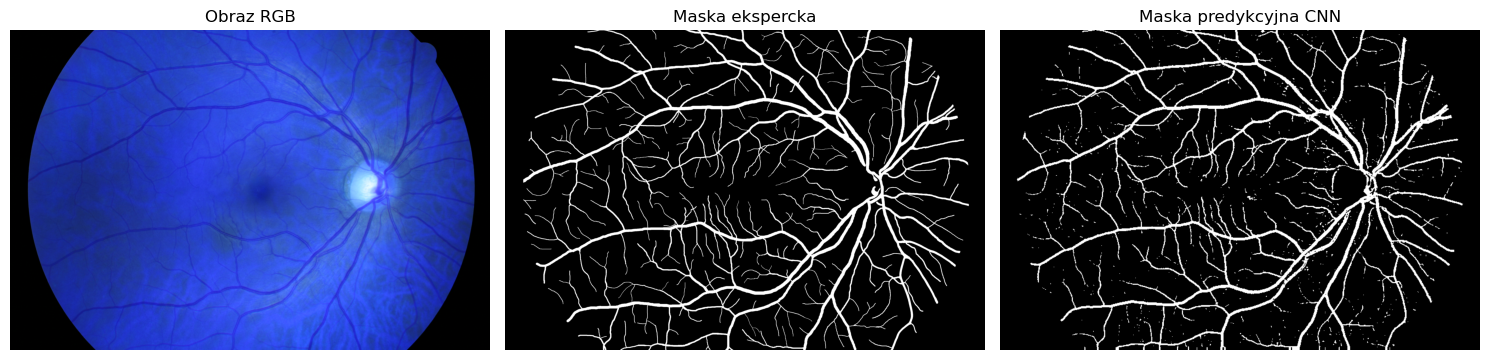

Confusion matrix:
 [[6905667  445789]
 [ 456669  377219]]
Accuracy: 0.8897
Sensitivity (Recall): 0.4524
Specificity: 0.9394
Balanced Accuracy: 0.6959


In [5]:
if selected_index is None:
    print("Najpierw wybierz obraz z dropdowna.")
else:
    window_size = 20
    step = 4
    image = images[selected_index]
    mask = (masks[selected_index] > 127).astype(np.uint8)

    # Rozmycie i CLAHE
    # img_blur = cv2.GaussianBlur(image, (5, 5), 0)
    # b, g, r = cv2.split(img_blur)
    # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # b_clahe = clahe.apply(b)
    # g_clahe = clahe.apply(g)
    # r_clahe = clahe.apply(r)
    # img_eq = cv2.merge((b_clahe, g_clahe, r_clahe))

    # # Konwersja do szarości
    # gray = rgb2gray(cv2.cvtColor(img_eq, cv2.COLOR_BGR2RGB))
    # gray = (gray * 255).astype('uint8')
    
    img_blur = cv2.GaussianBlur(image, (5, 5), 0)
    green_channel = img_blur[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    g_clahe = clahe.apply(green_channel)
    gray = (g_clahe * 255).astype('uint8')

    # Patchowanie
    h, w = gray.shape
    patches_test, positions_test = [], []

    for y in range(0, h - window_size + 1, step):
        for x in range(0, w - window_size + 1, step):
            center_y = y + window_size // 2
            center_x = x + window_size // 2
            if center_y >= h or center_x >= w:
                continue

            patch = gray[y:y+window_size, x:x+window_size].astype('float32') / 255.0
            patch = patch[..., np.newaxis]
            patches_test.append(patch)
            positions_test.append((y, x))

    X_test_single = np.array(patches_test)

    # Predykcja
    y_pred_test = (model.predict(X_test_single, verbose=0) > 0.5).astype(np.uint8).flatten()

    # Rekonstrukcja maski
    output_mask_pred = np.zeros_like(gray, dtype=np.uint8)
    for idx, (y, x) in enumerate(positions_test):
        output_mask_pred[y:y+window_size, x:x+window_size] = y_pred_test[idx]

    # Wyświetlenie wyników
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Obraz RGB")
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Maska ekspercka")
    axes[1].axis('off')

    axes[2].imshow(output_mask_pred, cmap='gray')
    axes[2].set_title("Maska predykcyjna CNN")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Oblicz metryki
    TP = np.logical_and(output_mask_pred == 1, mask == 1).sum()
    TN = np.logical_and(output_mask_pred == 0, mask == 0).sum()
    FP = np.logical_and(output_mask_pred == 1, mask == 0).sum()
    FN = np.logical_and(output_mask_pred == 0, mask == 1).sum()

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    balanced_accuracy = (sensitivity + specificity) / 2
    cm = confusion_matrix(mask.flatten(), output_mask_pred.flatten())

    print("Confusion matrix:\n", cm)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")